# PRMT-2346 Hypothesis: Attachments are increasing in size over time

We believe that GP2GP records are getting bigger
We will know this to be true when we see either the number of attachments per transfer or the size of attachments increasing over time. 

Context
We see a steady increase of EMIS-TPP Large message general failures over the last 4 months. A hypothesis for this is that records are steadily getting bigger, either in terms of size of attachments or number of attachments. We want to perform analysis to see if in general, the number of attachments per record or the size of attachments is increasing. 

Scope
Look at data for June, July, August

Analyse the number and size of attachments across these months.

If there is an increase in the number of attachments, what attachment types are we seeing more of? What seem to be the biggest types of attachments?

In [40]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Load attachment data

1. Log into Splunk and run the following query for:
- 01/06/2021 00:00:00:00 to 30/06/2021 24:00:00 (using Date Range) and export the result as a CSV, gzip and name `6-2021-attachment-metadata.csv.gz`
- 01/07/2021 00:00:00:00 to 31/07/2021 24:00:00 (using Date Range) and export the result as a CSV, gzip and name `7-2021-attachment-metadata.csv.gz`
- 01/08/2021 00:00:00:00 to 31/08/2021 24:00:00 (using Date Range) and export the result as a CSV, gzip and name `8-2021-attachment-metadata.csv.gz`

index="spine2vfmmonitor" logReference=MPS0208
| table _time, attachmentID, conversationID, FromSystem, ToSystem, attachmentType, Compressed, ContentType, LargeAttachment, Length, OriginalBase64, internalID, DomainData

2. Run the following Splunk query for the same time range. Export the results as a csvs named `6-2021-ehr-request-completed-messages.csv`, `7-2021-ehr-request-completed-messages.csv`, `8-2021-ehr-request-completed-messages.csv` and gzip it.

index="spine2vfmmonitor" service="gp2gp" logReference="MPS0053d" interactionID="urn:nhs:names:services:gp2gp/RCMR_IN030000UK06"
| table _time, conversationID, internalID, interactionID

In [2]:
data_folder="s3://prm-gp2gp-notebook-data-prod/PRMT-2351-supplier-attachments/"
attachment_metadata_files = [
    "6-2021-attachment-metadata.csv.gz",
    "7-2021-attachment-metadata.csv.gz",
    "8-2021-attachment-metadata.csv.gz"
]

attachments = pd.concat([pd.read_csv(data_folder+file, parse_dates=["_time"], na_values=["Unknown"], dtype={"Length": pd.Int64Dtype()}) for file in attachment_metadata_files])

In [3]:
non_core_attachments_bool=attachments['DomainData']!='X-GP2GP-Skeleton: Yes'
attachments_real=attachments.loc[non_core_attachments_bool]

In [4]:
gp2gp_messages_files = [
    "6-2021-ehr-request-completed-messages.csv.gz",
    "7-2021-ehr-request-completed-messages.csv.gz",
    "8-2021-ehr-request-completed-messages.csv.gz"
]
ehr_request_completed_messages = pd.concat([pd.read_csv(data_folder+file, parse_dates=["_time"]) for file in gp2gp_messages_files])

## Deduplicate attachment data

In [5]:
unique_ehr_request_completed_messages = (
    ehr_request_completed_messages
        .sort_values(by="_time")
        .drop_duplicates(subset=["conversationID"], keep="last")
)

ehr_attachments = pd.merge(attachments_real, unique_ehr_request_completed_messages[["internalID", "interactionID"]], on="internalID", how="inner")

## A. Attachment sizes over time

In [6]:
# Extract month and date from the time stamp. Convert length to MB 
ehr_attachments['Month'] = ehr_attachments['_time'].dt.to_period('M')
ehr_attachments['Date'] = ehr_attachments['_time'].dt.to_period('D')
ehr_attachments['Length in MB'] = ehr_attachments["Length"].fillna(0)/(1024**2)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


<AxesSubplot:xlabel='Date'>

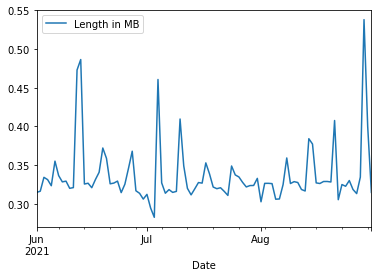

In [7]:
# Check avaerage daily attachment size over time
ehr_attachments_grouped_by_day = ehr_attachments.groupby(by="Date").agg({"Length in MB": "mean"})
ehr_attachments_grouped_by_day.plot(kind='line')

In [128]:
# Format float outputs to more readable numbers
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [152]:
# Calculate summary statistics for each month - Attachment sizes

june_bool = ehr_attachments['Month'] == "2021-06"
june_ehr_attachments = ehr_attachments[june_bool]
june_ehr_attachments_summary = june_ehr_attachments[["Length in MB"]].describe().rename(columns={"Length in MB": "June"})

july_bool = ehr_attachments['Month'] == "2021-07"
july_ehr_attachments = ehr_attachments[july_bool]
july_ehr_attachments_summary = july_ehr_attachments[["Length in MB"]].describe().rename(columns={"Length in MB": "July"})

august_bool = ehr_attachments['Month'] == "2021-08"
august_ehr_attachments = ehr_attachments[august_bool]
august_ehr_attachments_summary = august_ehr_attachments[["Length in MB"]].describe().rename(columns={"Length in MB": "August"})

pd.concat([june_ehr_attachments_summary, july_ehr_attachments_summary, august_ehr_attachments_summary], axis=1)

,June,July,August
count,8557642.00000,8507119.00000,8229793.00000
mean,0.32457,0.31931,0.32310
std,1.96605,1.92463,1.89743
min,0.00000,0.00000,0.00000
25%,0.01538,0.01534,0.01552
50%,0.04344,0.04354,0.04396
75%,0.11906,0.11893,0.12152
max,528.96182,755.80851,289.18650


## B. Attachment sizes over time with TPP as sender

In [151]:
# Calculate summary statistics of attachments with TPP as sender

ttp_sender_bool = ehr_attachments["FromSystem"] == "SystmOne"

tpp_june_attachments = june_ehr_attachments[ttp_sender_bool]
tpp_june_summary = tpp_june_attachments[["Length in MB"]].describe().rename(columns={"Length in MB": "June"})

tpp_july_attachments = july_ehr_attachments[ttp_sender_bool]
tpp_july_summary = tpp_july_attachments[["Length in MB"]].describe().rename(columns={"Length in MB": "July"})

tpp_august_attachments = august_ehr_attachments[ttp_sender_bool]
tpp_august_summary = tpp_august_attachments[["Length in MB"]].describe().rename(columns={"Length in MB": "August"})

pd.concat([tpp_june_summary, tpp_july_summary, tpp_august_summary], axis=1)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,June,July,August
count,1755604.00000,1717241.00000,1684655.00000
mean,0.48360,0.48260,0.48488
std,1.42154,1.41345,1.41814
min,0.00000,0.00000,0.00000
25%,0.02824,0.02798,0.02801
50%,0.06790,0.06815,0.06882
75%,0.32185,0.32273,0.33041
max,61.34062,61.53141,83.50857


## C. Number of attachments over time

In [153]:
# Group attachements by conversation to get a count of attachments for each
ehr_attachments_grouped_by_conversation = ehr_attachments.groupby(by="conversationID").agg({"Length": "count", "Date" : "max", "Month": "max"})

In [154]:
# Calculate summary statistics for each month - number of attachements

june_bool = ehr_attachments_grouped_by_conversation['Month'] == "2021-06"
june_attachments = ehr_attachments_grouped_by_conversation[june_bool]
june_summary = june_attachments.describe().rename(columns={"Length": "June"})

july_bool = ehr_attachments_grouped_by_conversation['Month'] == "2021-07"
july_attachments = ehr_attachments_grouped_by_conversation[july_bool]
july_summary =july_attachments.describe().rename(columns={"Length": "July"})

august_bool = ehr_attachments_grouped_by_conversation['Month'] == "2021-08"
august_attachments = ehr_attachments_grouped_by_conversation[august_bool]
august_summary = august_attachments.describe().rename(columns={"Length": "August"})

pd.concat([june_summary, july_summary, august_summary], axis=1)

,June,July,August
count,129477.00000,126280.00000,124201.00000
mean,66.09364,67.36679,66.26146
std,65.20358,65.23506,64.66335
min,0.00000,0.00000,0.00000
25%,25.00000,26.00000,25.00000
50%,46.00000,48.00000,47.00000
75%,84.00000,86.00000,84.00000
max,1484.00000,1156.00000,1340.00000


## D. Number of attachments over time with TPP as sender

In [155]:
# Calculate summary statistics of number of attachments with TPP as sender

tpp_sender_attachments = ehr_attachments[ttp_sender_bool]

tpp_ehr_attachments_grouped_by_conversation = tpp_sender_attachments.groupby(by="conversationID").agg({"Length": "count", "Date" : "max", "Month": "max"})
tpp_june_bool = tpp_ehr_attachments_grouped_by_conversation['Month'] == "2021-06"
tpp_june_attachments = tpp_ehr_attachments_grouped_by_conversation[tpp_june_bool]
tpp_june_summary = tpp_june_attachments.describe().rename(columns={"Length": "June"})

tpp_july_bool = tpp_ehr_attachments_grouped_by_conversation['Month'] == "2021-07"
tpp_july_attachments = tpp_ehr_attachments_grouped_by_conversation[tpp_july_bool]
tpp_july_summary =tpp_july_attachments.describe().rename(columns={"Length": "July"})

tpp_august_bool = tpp_ehr_attachments_grouped_by_conversation['Month'] == "2021-08"
tpp_august_attachments = tpp_ehr_attachments_grouped_by_conversation[tpp_august_bool]
tpp_august_summary = tpp_august_attachments.describe().rename(columns={"Length": "August"})

pd.concat([tpp_june_summary, tpp_july_summary, tpp_august_summary], axis=1)

,June,July,August
count,35162.00000,32443.00000,32319.00000
mean,49.92901,52.93102,52.12584
std,55.26144,56.24711,55.05555
min,1.00000,1.00000,1.00000
25%,15.00000,17.00000,17.00000
50%,32.00000,35.00000,35.00000
75%,63.00000,68.00000,67.00000
max,837.00000,1118.00000,1209.00000


## Findings

There doesn't seem to be any significant changes in number of attachments and its sizes over time.

### Experimenting with visualising the data

<AxesSubplot:title={'center':'Length'}, xlabel='[Month]'>

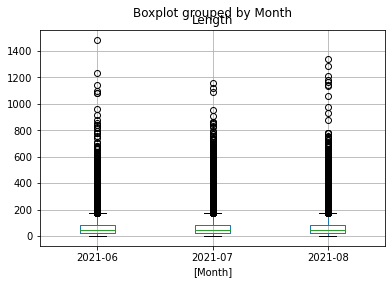

In [138]:
ehr_attachments_grouped_by_conversation.boxplot(by='Month')

array([[<AxesSubplot:title={'center':'Length'}>]], dtype=object)

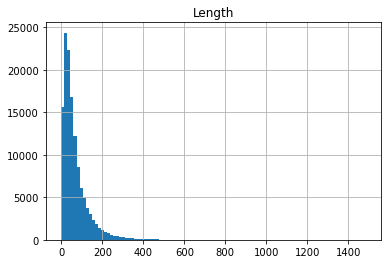

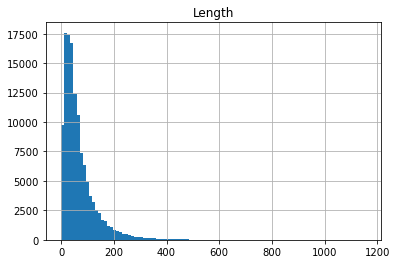

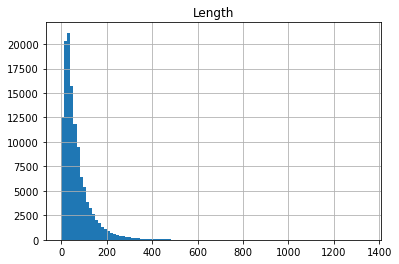

In [139]:
june_attachments.hist(bins=100)
july_attachments.hist(bins=100)
august_attachments.hist(bins=100)

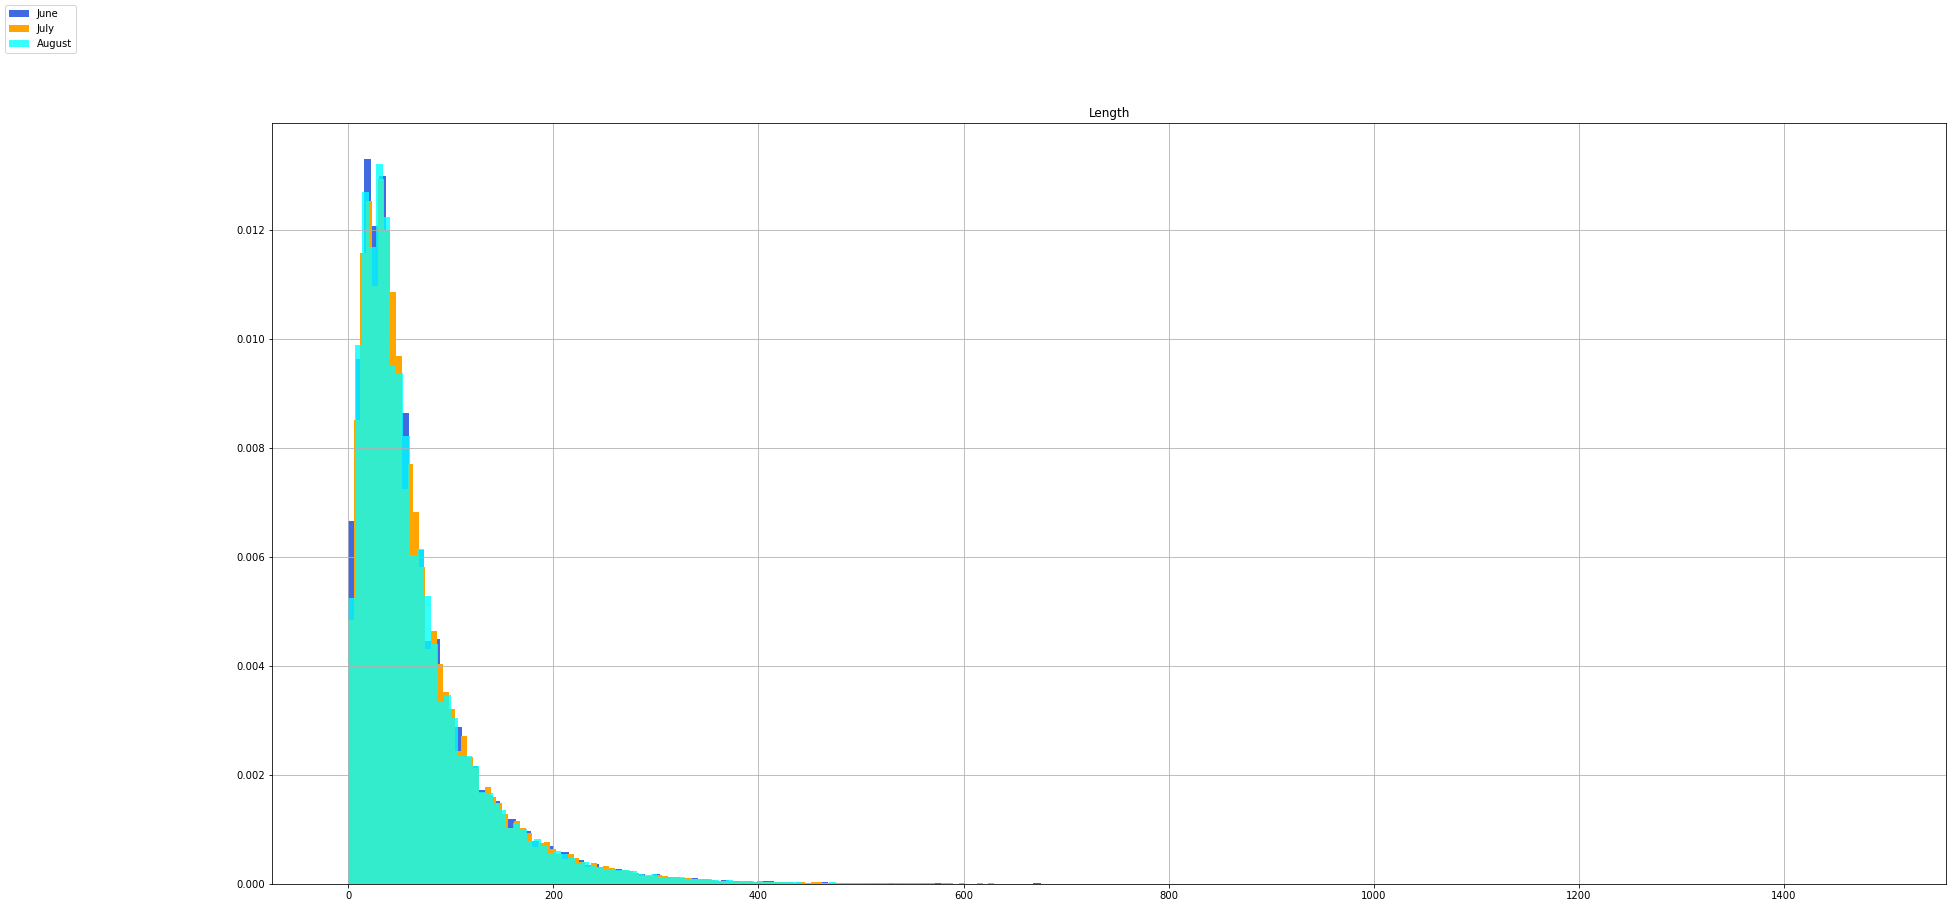

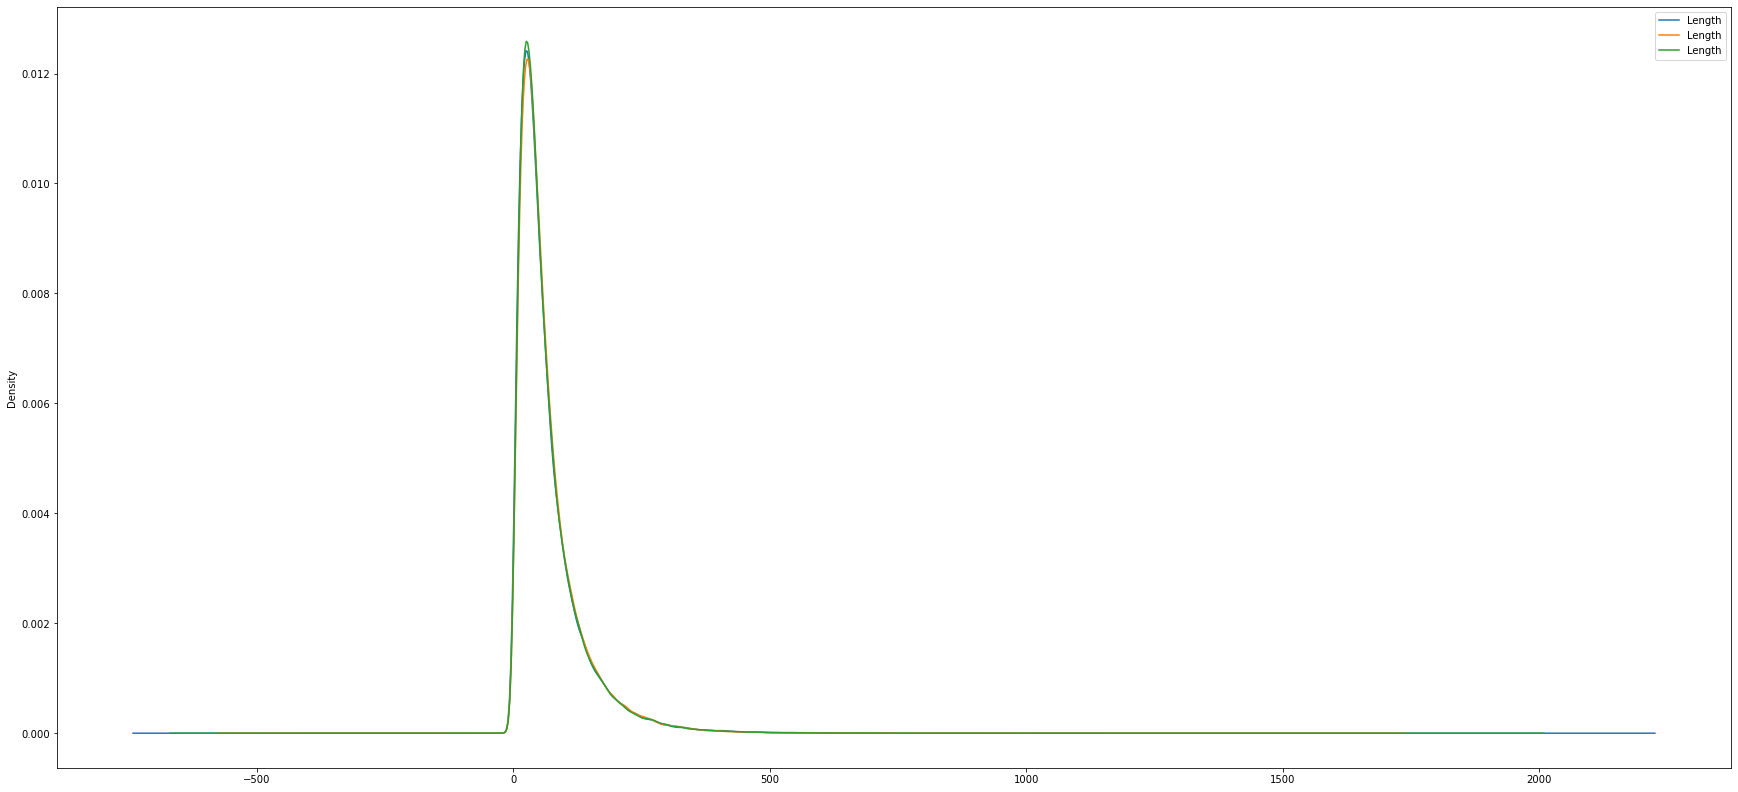

In [140]:
fig, ax = plt.subplots(figsize=(30,14))
fig2, ax2 = plt.subplots(figsize=(30,14))

june_attachments.hist(bins=200, density=True, ax=ax, label='June', color='royalblue')
june_attachments.plot(kind="kde", ax=ax2, label='June')

july_attachments.hist(bins=200, density=True, ax=ax, label='July', color='orange')
july_attachments.plot(kind="kde", ax=ax2, label='July')

august_attachments.hist(bins=200, density=True, ax=ax, label='August', alpha=0.8 , color='cyan')
august_attachments.plot(kind="kde", ax=ax2, label='August')

fig.legend(loc=2)